In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate


def zcsequence(u, seq_length, q=0):
    """
    Generate a Zadoff-Chu (ZC) sequence.

    Parameters
    ----------
    u : int
        Root index of the the ZC sequence: u>0.

    seq_length : int
        Length of the sequence to be generated. Usually a prime number:
        u<seq_length, greatest-common-denominator(u,seq_length)=1.

    q : int
        Cyclic shift of the sequence (default 0).

    Returns
    -------
    zcseq : 1D ndarray of complex floats
        ZC sequence generated.
    """

    for el in [u, seq_length, q]:
        if not float(el).is_integer():
            raise ValueError("{} is not an integer".format(el))
    if u <= 0:
        raise ValueError("u is not stricly positive")
    if u >= seq_length:
        raise ValueError("u is not stricly smaller than seq_length")
    if np.gcd(u, seq_length) != 1:
        raise ValueError("the greatest common denominator of u and seq_length is not 1")

    cf = seq_length % 2
    n = np.arange(seq_length)
    zcseq = np.exp(-1j * np.pi * u * n * (n + cf + 2.0 * q) / seq_length)

    return zcseq

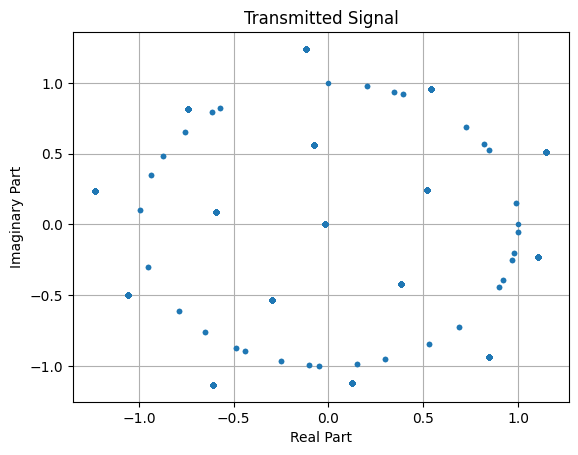

The transmitted signal is of type: <class 'numpy.complex64'>


In [7]:
# Example settings
u = 5
zc_length = 62
message_length = 1000
snr_dB = 20  # Signal-to-noise ratio (dB)

# Generate ZC sequence
zc_seq = zcsequence(u, zc_length)

# Generate 16-QAM signal
# Read the constellation points from the txt file
tx_read = np.loadtxt(f"./16qam_constellation.txt")
# Extract the real and imaginary parts
tx_constellation = tx_read[:, 0] + 1j * tx_read[:, 1]

# Normalize the constellation
tx_constellation = tx_constellation / np.sqrt(np.mean(np.abs(tx_constellation) ** 2))

# Generate the message
message = np.random.randint(0, 16, message_length)
qam_signal = tx_constellation[message]

# Normalize the ZC sequence
normalized_zc_seq = zc_seq / np.sqrt(np.mean(np.abs(zc_seq) ** 2))

# Add the normalized ZC sequence to the 16-QAM signal
transmitted_signal = np.concatenate([normalized_zc_seq, qam_signal])

# Convert to complex float32
transmitted_signal = transmitted_signal.astype(np.complex64)

# Write the transmitted signal to a dat file
with open("./file/tx.dat", "wb") as f:
    f.write(transmitted_signal.tobytes())

# Plot the transmitted signal
plt.figure()
plt.plot(np.real(transmitted_signal), np.imag(transmitted_signal), ".")
plt.title("Transmitted Signal")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid()
plt.show()

# Print the type of the transmitted signal
print("The transmitted signal is of type: {}".format(type(transmitted_signal[0])))

Detected start index: -3


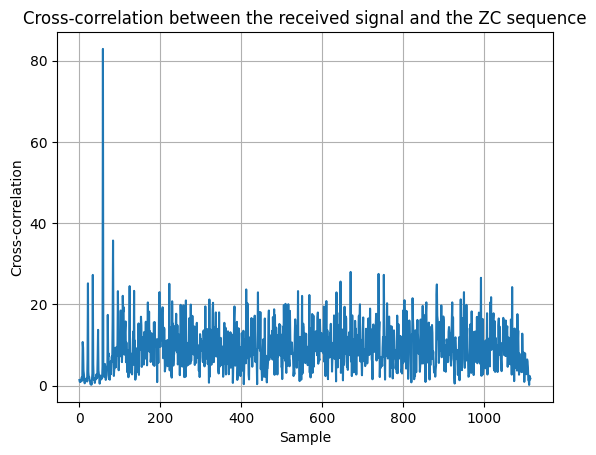

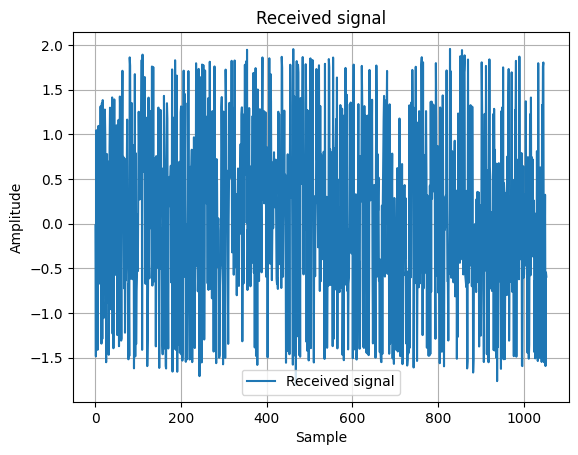

In [11]:
# Read the received signal from a binary file
with open("./file/rx.dat", "rb") as f:
    rx = np.frombuffer(f.read(), dtype=np.complex64)

# Compute the cross-correlation between the received signal and the ZC sequence
cross_correlation = correlate(rx, zc_seq, mode="full")
peak_index = np.argmax(np.abs(cross_correlation)) - zc_length + 1
print(f"Detected start index: {peak_index}")

# Plot the cross-correlation
plt.figure()
plt.plot(np.abs(cross_correlation))
plt.title("Cross-correlation between the received signal and the ZC sequence")
plt.xlabel("Sample")
plt.ylabel("Cross-correlation")
plt.grid()
plt.show()

# Plot the transmitted and received signals
plt.figure()
plt.plot(np.real(rx), label="Received signal")
plt.title("Received signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()